# Movies feelings analysis

## Importando bibliotecas

In [ ]:
# === 1) Imports & setup ===
import os, re, random
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
sns.set_theme()  # estilo visual do seaborn

RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Pastas para salvar saídas
os.makedirs('reports', exist_ok=True)

In [4]:

# Carregar dados
df = pd.read_csv('/content/imdb_dataset.csv')
df = df.rename(columns={'review': 'text', 'sentiment': 'label'})


In [5]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [6]:
# === 3) Sanidade básica ===
print("Formato:", df.shape)
print(df.head(3))
print("Nulos por coluna:\n", df.isna().sum())


Formato: (50000, 2)
                                                text     label
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
Nulos por coluna:
 text     0
label    0
dtype: int64


In [7]:
# Procuramos por duplicatas exatas (texto, label) e imprimimos alguns exemplos

before = len(df)
dups_exact = df.duplicated(subset=['text','label'], keep=False)
print("Duplicatas exatas (text+label):", dups_exact.sum())

# Amostra de 5 pares (mesmo text+label)
ex_dups = (df.loc[dups_exact, ['text','label']]
             .groupby(['text','label'])
             .head(2)  # mostra duas ocorrências
             .head(10))  # limita linhas exibidas

# Trunca os textos para visualizar melhor
ex_dups_display = ex_dups.copy()
ex_dups_display['text'] = ex_dups_display['text'].str.slice(0, 220)
ex_dups_display

Duplicatas exatas (text+label): 824


,text,label
42,"Of all the films I have seen, this one, The Ra...",negative
84,"We brought this film as a joke for a friend, a...",negative
140,"Before I begin, let me get something off my ch...",negative
219,Ed Wood rides again. The fact that this movie ...,negative
245,I have seen this film at least 100 times and I...,positive
480,From director Barbet Schroder (Reversal of For...,negative
513,"The story and the show were good, but it was r...",negative
636,I rented this thinking it would be pretty good...,negative
638,This movie has everything typical horror movie...,positive
701,I Enjoyed Watching This Well Acted Movie Very ...,positive


In [8]:
"""
Removemos duplicatas exatas por (text, label) para evitar contagem dupla de exemplos idênticos.
Em seguida, auditamos textos repetidos com rótulos conflitantes, apenas reportando sua frequência para decisão futura.
O processo foi realizado antes da divisão treino/validação para mitigar vazamento de dados.
"""
before = len(df)

# 1) Remover duplicatas exatas (texto + rótulo)
df = df.drop_duplicates(subset=['text', 'label']).reset_index(drop=True)

# 2) Auditar conflitos de rótulo para o mesmo texto
conflict_mask = df.duplicated(subset=['text'], keep=False)
conflicts = (df.loc[conflict_mask]
               .groupby('text')['label']
               .nunique()
               .reset_index(name='n_labels'))
n_conflicts = (conflicts['n_labels'] > 1).sum()

after = len(df)
print(f"Removidas {before - after} duplicatas exatas (texto+label).")
print(f"Textos com rótulos conflitantes: {n_conflicts}")

Removidas 418 duplicatas exatas (texto+label).
Textos com rótulos conflitantes: 0


Identificamos 824 linhas pertencentes a 406 grupos de duplicatas exatas por (text,label). Mantivemos uma ocorrência por grupo e removemos 418 linhas duplicadas, antes do split de treino/validação (alguns grupos tinham mais de duas ocorrências).

In [9]:
# remover <br>, <br/>, <br /> e colapsar espaços
df['text'] = df['text'].str.replace(r'<br\s*/?>', ' ', regex=True)
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# checando se sobrou alguma coisa
restantes = df['text'].str.contains(r'<br\s*/?>', regex=True).sum()
print("Ocorrências de <br> restantes:", restantes)

Ocorrências de <br> restantes: 0


In [10]:
# Schema simples (contrato de dados)
assert df['text'].map(lambda x: isinstance(x, str)).all(), "Há linhas sem texto (não-string)."
assert set(df['label'].unique()) <= {'positive','negative'}, "Labels fora do conjunto esperado."

# Confirmação (só é executado se as verificações acima forem verdadeiras)
print(
    "OK: schema verificado — coluna 'text' é string e 'label' contém apenas {'positive','negative'}.\n"
    f"Registros: {len(df)} | Distribuição de classes: {df['label'].value_counts().to_dict()}"
)

# Salvar dataset limpo
CSV_OUT = '/content/data-processed/imdb_clean.csv'
os.makedirs('/content/data-processed', exist_ok=True)

df_clean = df[['text','label']].copy()
df_clean.to_csv(CSV_OUT, index=False)

# feedback útil
counts = df_clean['label'].value_counts().to_dict()
print(f"Salvo: {CSV_OUT} | Registros: {len(df_clean)} | Distribuição: {counts}")

OK: schema verificado — coluna 'text' é string e 'label' contém apenas {'positive','negative'}.
Registros: 49582 | Distribuição de classes: {'positive': 24884, 'negative': 24698}
Salvo: /content/data-processed/imdb_clean.csv | Registros: 49582 | Distribuição: {'positive': 24884, 'negative': 24698}


      label  count    pct
0  positive  24884  50.19
1  negative  24698  49.81


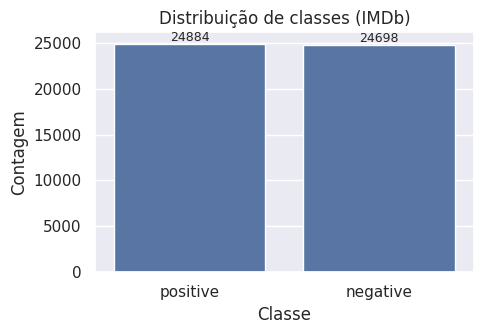

In [11]:
# === 4) Distribuição de classes ===
counts = (df['label']
          .value_counts()
          .rename_axis('label')
          .reset_index(name='count'))
counts['pct'] = (counts['count'] / counts['count'].sum() * 100).round(2)
print(counts)

plt.figure(figsize=(5,3.5))
ax = sns.barplot(data=counts, x='label', y='count')
ax.set_title('Distribuição de classes (IMDb)')
ax.set_xlabel('Classe'); ax.set_ylabel('Contagem')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.savefig('reports/class_balance.png', dpi=150)
plt.show()

count    49582.000000
mean       229.059639
std        169.789156
min          4.000000
25%        125.000000
50%        172.000000
75%        278.000000
max       2459.000000
Name: text_len, dtype: float64


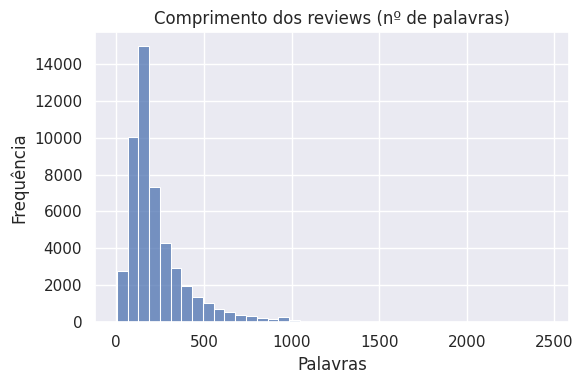

In [12]:
# === 5) Comprimento dos textos ===
df['text_len'] = df['text'].str.split().str.len()
print(df['text_len'].describe())

plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=40)
plt.title('Comprimento dos reviews (nº de palavras)')
plt.xlabel('Palavras'); plt.ylabel('Frequência')
plt.tight_layout(); plt.savefig('reports/text_len_hist.png', dpi=150)
plt.show()


In [13]:
# === 6) Exemplos de linhas (1 pos, 1 neg, 1 mediano por comprimento) ===
ex_pos = df[df['label']=='positive'].sample(1, random_state=RANDOM_STATE)['text'].iloc[0]
ex_neg = df[df['label']=='negative'].sample(1, random_state=RANDOM_STATE)['text'].iloc[0]
mid_idx = (df['text_len'] - df['text_len'].median()).abs().sort_values().index[0]
ex_mid = df.loc[mid_idx, 'text']

print("\nEXEMPLO POSITIVO:\n", ex_pos[:140], "\n")
print("EXEMPLO NEGATIVO:\n", ex_neg[:140], "\n")


EXEMPLO POSITIVO:
 Not since The Simpsons made it's debut has there been a sitcom that I didn't want to turn of in a matter of 2 minutes. It has of course been 

EXEMPLO NEGATIVO:
 I usually much prefer French movies over American ones, with explosions and car chases, but this movie was very disappointing. There is no w 



In [14]:
# === 7) Top termos por classe (limpeza simples) ===
stop_en = set(stopwords.words('english'))

def basic_clean(s: str):
    s = s.lower()
    s = re.sub(r'http\S+|www\.\S+', ' ', s)     # URLs
    s = re.sub(r'[^a-z\s]', ' ', s)             # mantém só letras e espaço
    toks = [w for w in s.split() if w not in stop_en and len(w) > 2]
    return toks

from collections import Counter

def top_words(subdf, k=15, cap=20000):
    c = Counter()
    # limitar a cap linhas p/ rapidez (ajuste se quiser)
    for t in subdf['text'].head(cap):
        c.update(basic_clean(t))
    top = pd.DataFrame(c.most_common(k), columns=['term','count'])
    return top

top_pos = top_words(df[df['label']=='positive'], k=15)
top_neg = top_words(df[df['label']=='negative'], k=15)

top_pos.to_csv('reports/top_terms_positive.csv', index=False)
top_neg.to_csv('reports/top_terms_negative.csv', index=False)
print("\nTop termos (positive):\n", top_pos.head())
print("\nTop termos (negative):\n", top_neg.head())


Top termos (positive):
     term  count
0   film  33575
1  movie  30459
2    one  21849
3   like  14104
4   good  12107

Top termos (negative):
     term  count
0  movie  40147
1   film  30079
2    one  20937
3   like  17936
4   even  12278


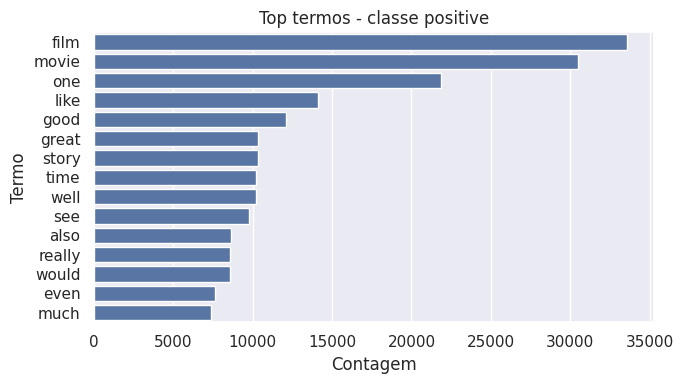

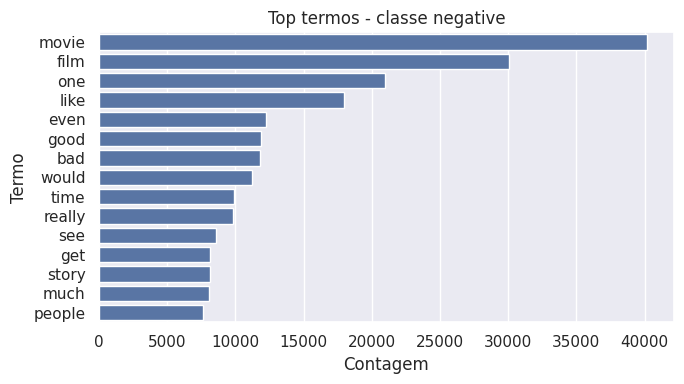

In [15]:
# Plots dos top termos
plt.figure(figsize=(7,4))
sns.barplot(data=top_pos, x='count', y='term')
plt.title('Top termos - classe positive')
plt.xlabel('Contagem'); plt.ylabel('Termo')
plt.tight_layout(); plt.savefig('reports/top_terms_positive.png', dpi=150)
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=top_neg, x='count', y='term')
plt.title('Top termos - classe negative')
plt.xlabel('Contagem'); plt.ylabel('Termo')
plt.tight_layout(); plt.savefig('reports/top_terms_negative.png', dpi=150)
plt.show()

In [17]:
# ETAPA 3, carregando o CSV limpo

CSV_CLEAN = '/content/data-processed/imdb_clean.csv'

assert os.path.exists(CSV_CLEAN), f"Arquivo não encontrado: {CSV_CLEAN}"
df_clean = pd.read_csv(CSV_CLEAN)
assert {'text','label'}.issubset(df_clean.columns)
print(df_clean.shape, df_clean['label'].value_counts(normalize=True).round(3).to_dict())


(49582, 2) {'positive': 0.502, 'negative': 0.498}


In [18]:
shape = df_clean.shape
dist = df_clean['label'].value_counts(normalize=True).round(3).to_dict()
print(
    "Dataset limpo carregado:\n"
    f"- Linhas x Colunas: {shape[0]} x {shape[1]}\n"
    f"- Colunas: {list(df_clean.columns)}\n"
    f"- Distribuição de classes: "
    f"positive={dist.get('positive',0)*100:.2f}% | negative={dist.get('negative',0)*100:.2f}%"
)


Dataset limpo carregado:
- Linhas x Colunas: 49582 x 2
- Colunas: ['text', 'label']
- Distribuição de classes: positive=50.20% | negative=49.80%


In [19]:
# Split estratificado 80/20

from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train, X_val, y_train, y_val = train_test_split(
    df_clean['text'], df_clean['label'],
    test_size=0.20, stratify=df_clean['label'], random_state=RANDOM_STATE
)

def dist(series):
    return series.value_counts(normalize=True).sort_index().round(3).to_dict()

print(
    "Split estratificado 80/20 concluído (random_state=42).\n"
    f"- Treino: {len(X_train)} registros | Distribuição: {dist(y_train)}\n"
    f"- Validação: {len(X_val)} registros | Distribuição: {dist(y_val)}"
)


Split estratificado 80/20 concluído (random_state=42).
- Treino: 39665 registros | Distribuição: {'negative': 0.498, 'positive': 0.502}
- Validação: 9917 registros | Distribuição: {'negative': 0.498, 'positive': 0.502}


In [21]:
# TF-IDF + Regressão Logística + GridSearch (k=5, F1)
# - Converte os reviews em vetores numéricos com TF-IDF.
# - Treina Regressão Logística (com L2) para classificar positivo/negativo.
# - Usa validação cruzada estratificada (5 folds) e GridSearch para escolher o melhor C via F1.
# - Define F1 com classe positiva explícita para evitar NaN (labels são strings).
# - Devolve o melhor pipeline (vetorizador + modelo) para avaliar no hold-out de 20%.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import pandas as pd

# sanity check opcional (mostra labels do treino)
print("Labels no treino:", sorted(y_train.unique()))  # esperado: ['negative', 'positive']

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=5)),
    ('clf', LogisticRegression(penalty='l2', max_iter=1000, random_state=RANDOM_STATE))
])

param_grid = {'clf__C': [0.1, 1, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# >>> scorer com classe positiva explícita
f1_pos_scorer = make_scorer(f1_score, pos_label='positive')

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=f1_pos_scorer,   # <-- evita NaN
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

grid.fit(X_train, y_train)

print("Melhor C:", grid.best_params_['clf__C'], "| F1 médio (CV):", round(grid.best_score_, 4))
pd.DataFrame(grid.cv_results_).to_csv('reports/cv_results_logreg_tfidf.csv', index=False)



Labels no treino: ['negative', 'positive']
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Melhor C: 1 | F1 médio (CV): 0.8931


Hold-out 20% -> F1=0.896 | Precisão=0.881 | Recall=0.911


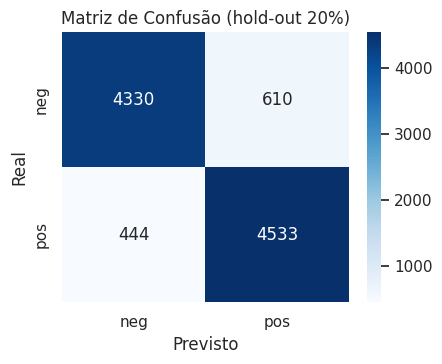

              precision    recall  f1-score   support

    negative      0.907     0.877     0.891      4940
    positive      0.881     0.911     0.896      4977

    accuracy                          0.894      9917
   macro avg      0.894     0.894     0.894      9917
weighted avg      0.894     0.894     0.894      9917



In [22]:
# AVALIAÇÃO NO HOLD-OUT (20%) + MATRIZ DE CONFUSÃO
# - Usa o melhor pipeline do GridSearch (TF-IDF + LogReg) para prever no conjunto de validação (20%).
# - Calcula métricas principais para a classe positiva: F1 (principal), Precisão e Recall.
# - Salva um CSV com as métricas em reports/metrics_holdout.csv.
# - Gera e salva a Matriz de Confusão em reports/confusion_matrix.png.
#   * Linhas = rótulo real; Colunas = rótulo previsto; ordem: ['negative','positive'].


import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

f1  = f1_score(y_val, y_pred, pos_label='positive')
pre = precision_score(y_val, y_pred, pos_label='positive')
rec = recall_score(y_val, y_pred, pos_label='positive')
print(f"Hold-out 20% -> F1={f1:.3f} | Precisão={pre:.3f} | Recall={rec:.3f}")

pd.DataFrame([{'f1':f1, 'precision':pre, 'recall':rec}]).to_csv('reports/metrics_holdout.csv', index=False)

cm = confusion_matrix(y_val, y_pred, labels=['negative','positive'])
plt.figure(figsize=(4.6,3.8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.title('Matriz de Confusão (hold-out 20%)'); plt.xlabel('Previsto'); plt.ylabel('Real')
plt.tight_layout(); plt.savefig('reports/confusion_matrix.png', dpi=150); plt.show()

print(classification_report(y_val, y_pred, digits=3))


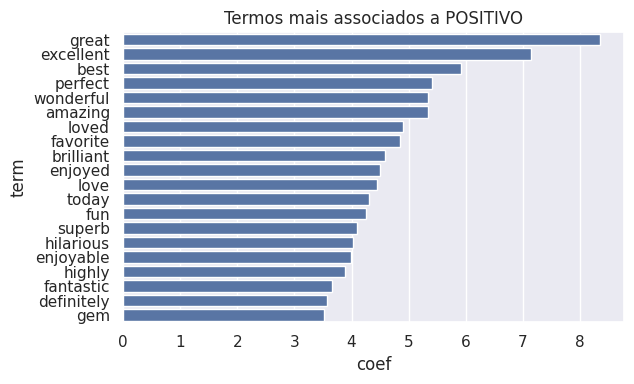

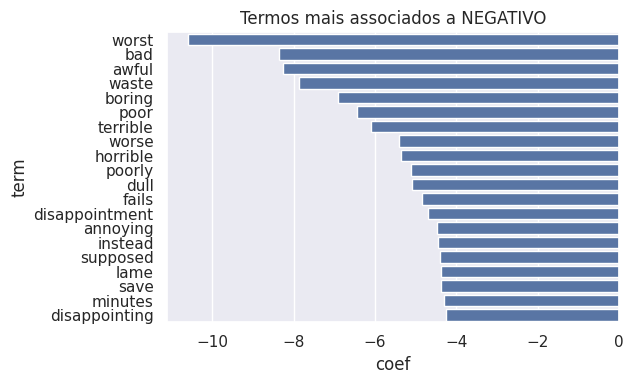

In [23]:
# INTERPRETABILIDADE — Termos mais influentes (coeficientes da Regressão Logística)
# - Extrai o vocabulário do TF-IDF e os coeficientes do classificador (classe 'positive').
# - Coeficiente > 0: termo puxa a predição para POSITIVO; coeficiente < 0: puxa para NEGATIVO.
# - Seleciona os 20 maiores coeficientes (positivos) e os 20 menores (negativos).
# - Salva as tabelas em CSV.
# - Gera gráficos de barras e salva em PNG.


import numpy as np, pandas as pd

tfidf = best_model.named_steps['tfidf']
clf   = best_model.named_steps['clf']

terms = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_.ravel()

top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

top_pos = pd.DataFrame({'term': terms[top_pos_idx], 'coef': coefs[top_pos_idx]})
top_neg = pd.DataFrame({'term': terms[top_neg_idx], 'coef': coefs[top_neg_idx]})

top_pos.to_csv('reports/top_coefficients_positive.csv', index=False)
top_neg.to_csv('reports/top_coefficients_negative.csv', index=False)

plt.figure(figsize=(6.5,4)); sns.barplot(data=top_pos, x='coef', y='term'); plt.title('Termos mais associados a POSITIVO')
plt.tight_layout(); plt.savefig('reports/top_coefficients_positive.png', dpi=150); plt.show()

plt.figure(figsize=(6.5,4)); sns.barplot(data=top_neg, x='coef', y='term'); plt.title('Termos mais associados a NEGATIVO')
plt.tight_layout(); plt.savefig('reports/top_coefficients_negative.png', dpi=150); plt.show()


In [24]:
# ANÁLISE DE ERROS — Amostras de FP (falsos positivos) e FN (falsos negativos)
# - Constrói um DataFrame com texto real (X_val), rótulo verdadeiro (label) e previsão (pred).
# - Adiciona a probabilidade do modelo para a classe 'positive' (proba_pos).
# - Separa:
#   * FP: casos com label = 'negative' mas pred = 'positive'
#   * FN: casos com label = 'positive' mas pred = 'negative'
# - Cria versões truncadas dos textos (primeiros 500 caracteres) para facilitar leitura no relatório.
# - Salva 10 exemplos de cada tipo em CSV:
#   * reports/false_positives_sample.csv
#   * reports/false_negatives_sample.csv
# - O print final mostra quantos FP e FN existem no hold-out.

y_pred_proba = best_model.predict_proba(X_val)[:,1] if hasattr(best_model, "predict_proba") else None

val_df = pd.DataFrame({'text': X_val, 'label': y_val, 'pred': y_pred})
if y_pred_proba is not None:
    val_df['proba_pos'] = y_pred_proba

fp = val_df[(val_df['label']=='negative') & (val_df['pred']=='positive')].copy()
fn = val_df[(val_df['label']=='positive') & (val_df['pred']=='negative')].copy()
fp['text_trunc'] = fp['text'].str.slice(0, 500)
fn['text_trunc'] = fn['text'].str.slice(0, 500)

fp.head(10)[['text_trunc','label','pred','proba_pos'] if 'proba_pos' in fp else ['text_trunc','label','pred']].to_csv(
    'reports/false_positives_sample.csv', index=False)
fn.head(10)[['text_trunc','label','pred','proba_pos'] if 'proba_pos' in fn else ['text_trunc','label','pred']].to_csv(
    'reports/false_negatives_sample.csv', index=False)

print(f"FP: {len(fp)} | FN: {len(fn)}  (amostras salvas em reports/*_sample.csv)")



FP: 610 | FN: 444  (amostras salvas em reports/*_sample.csv)


In [26]:
# Salvar modelo e resumo dos resultados
# - Salva o pipeline completo (TF-IDF + Regressão Logística com melhor C) via joblib,
#   para reutilizar depois sem reprocessar o texto.
# - Gera um resumo em CSV com os principais números: melhor C, F1 no CV (k=5),
#   e métricas do hold-out (F1, Precisão, Recall).
# - Arquivos gerados:
#     • models/logreg_tfidf_pipeline.pkl  -> modelo pronto para carregar e prever
#     • reports/summary_stage3.csv        -> tabela com métricas-chave
# - Mantém reprodutibilidade: usamos random_state=42 em split/CV/treino.


import os
os.makedirs('models', exist_ok=True)
os.makedirs('reports', exist_ok=True)  # caso ainda não exista

import joblib, pandas as pd

# salvar o modelo
joblib.dump(best_model, 'models/logreg_tfidf_pipeline.pkl')

# salvar resumo
pd.DataFrame([{
    'best_C': grid.best_params_['clf__C'],
    'cv_f1_mean': round(grid.best_score_, 4),
    'holdout_f1': round(f1, 3),
    'holdout_precision': round(pre, 3),
    'holdout_recall': round(rec, 3)
}]).to_csv('reports/summary_stage3.csv', index=False)

print("OK: modelo salvo em models/logreg_tfidf_pipeline.pkl e resumo em reports/summary_stage3.csv")


OK: modelo salvo em models/logreg_tfidf_pipeline.pkl e resumo em reports/summary_stage3.csv
